# Chapter 6: Convert Horses to Zebras

# 1. CycleGAN and Cycle Consistency Loss

# 2. The Horse and Zebra Dataset
Download here https://www.kaggle.com/datasets/balraj98/horse2zebra-dataset 

## 2.1 Download the Horse and Zebra Dataset

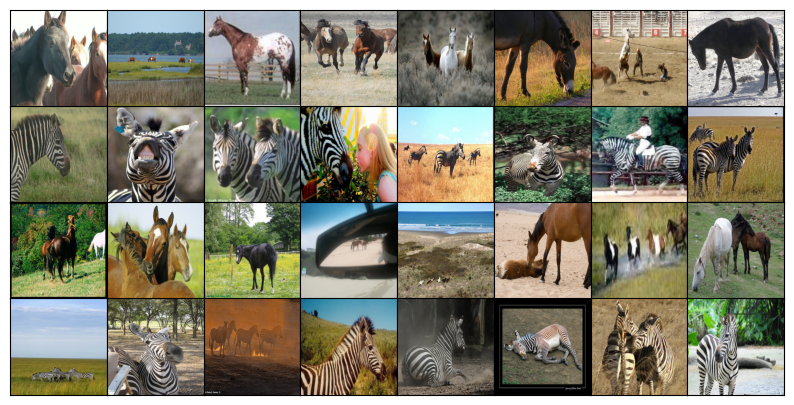

In [1]:
# Downlaod data at https://www.kaggle.com/datasets/balraj98/horse2zebra-dataset 
# place the four subfolders: trainA, trainB, testA, and testB, in the folder /files/ 
import os

trainA="files/trainA/"
trainB="files/trainB/"
testA="files/testA/"
testB="files/testB/"

trainA_imgs=os.listdir(trainA)
trainB_imgs=os.listdir(trainB) 
testA_imgs=os.listdir(testA)
testB_imgs=os.listdir(testB)

imgs=[]

folders=[trainA,trainB,testA,testB]
files=[trainA_imgs,trainB_imgs,testA_imgs,testB_imgs]

for folder,file in zip(folders,files):
    for j in range(8):
        imgs.append(folder+file[j])

import matplotlib.pyplot as plt
from PIL import Image
plt.figure(figsize=(10,5),dpi=100)
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    img=Image.open(f"{imgs[i]}")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.01,hspace=-0.01)    
plt.show()  

In [2]:
print(f"there are {len(trainA_imgs)} images in folder trainA")
print(f"there are {len(trainB_imgs)} images in folder trainB")
print(f"there are {len(testA_imgs)} images in folder testA")
print(f"there are {len(testB_imgs)} images in folder testB")

there are 1067 images in folder trainA
there are 1334 images in folder trainB
there are 120 images in folder testA
there are 140 images in folder testB


## 2.2. Preprocess the Data
Download the files *ch06util.py* and *__init__.py* from the book's GitHub repository and place it in the folder /Desktop/dgai/utils/ on your computer. In it, we have defined the following *LoadData()* class:

```python
class LoadData(Dataset):
    def __init__(self, root_A, root_B, transform=None):
        super().__init__()
        self.root_A = root_A
        self.root_B = root_B
        self.transform = transform
        self.A_images = []
        for r in root_A:
            files=os.listdir(r)
            self.A_images += [r+i for i in files]
        self.B_images = []
        for r in root_B:
            files=os.listdir(r)
            self.B_images += [r+i for i in files]      
        self.len_data = max(len(self.A_images),
                            len(self.B_images))
        self.A_len = len(self.A_images)
        self.B_len = len(self.B_images)
    def __len__(self):
        return self.len_data
    def __getitem__(self, index):
        A_img = self.A_images[index % self.A_len]
        B_img = self.B_images[index % self.B_len]
        A_img = np.array(Image.open(A_img).convert("RGB"))
        B_img = np.array(Image.open(B_img).convert("RGB"))
        if self.transform:
            augmentations = self.transform(image=B_img,
                                           image0=A_img)
            B_img = augmentations["image"]
            A_img = augmentations["image0"]
        return A_img, B_img 
```

In [3]:
from utils.ch06util import LoadData
from torch.utils.data import DataLoader
from tqdm import tqdm
import albumentations 
from albumentations.pytorch import ToTensorV2

transforms = albumentations.Compose(
    [albumentations.Resize(width=256, height=256),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.Normalize(mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],max_pixel_value=255),
        ToTensorV2()],
    additional_targets={"image0": "image"}) 
dataset = LoadData(root_A=[trainA,testA],
    root_B=[trainB,testB],
    transform=transforms)
loader=DataLoader(dataset,batch_size=1,
    shuffle=True, pin_memory=True)

# 3. CycleGAN to Convert Horses to Zebras

## 3.1. Bulit the Cycle GAN Model

Open the file *ch06util.py* you just downloaded. In it, we have defined the *Discriminator()* class as follows:

```python
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64,128,256,512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels,features[0],
                kernel_size=4,stride=2,padding=1,
                padding_mode="reflect"),
            nn.LeakyReLU(0.2, inplace=True))
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, 
                stride=1 if feature == features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels,1,kernel_size=4,
                stride=1,padding=1,padding_mode="reflect"))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        out = self.model(self.initial(x))
        return torch.sigmoid(out)
 ```

```python
def weights_init(m):
    name = m.__class__.__name__
    if name.find('Conv') != -1 or name.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif name.find('Norm2d') != -1:
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)   
```

In [4]:
from utils.ch06util import Discriminator, weights_init
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
disc_A = Discriminator().to(device)
disc_B = Discriminator().to(device)
weights_init(disc_A)
weights_init(disc_B)

```python
class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64,
                 num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels,num_features,kernel_size=7,
                stride=1,padding=3,padding_mode="reflect",),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True))
        self.down_blocks = nn.ModuleList(
            [ConvBlock(num_features,num_features*2,kernel_size=3,
                       stride=2, padding=1),
            ConvBlock(num_features*2,num_features*4,kernel_size=3,
                stride=2,padding=1)])
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) 
            for _ in range(num_residuals)])
        self.up_blocks = nn.ModuleList(
            [ConvBlock(num_features * 4, num_features * 2,
                    down=False, kernel_size=3, stride=2,
                    padding=1, output_padding=1),
                ConvBlock(num_features * 2, num_features * 1,
                    down=False,kernel_size=3, stride=2,
                    padding=1, output_padding=1)])
        self.last = nn.Conv2d(num_features * 1, img_channels,
            kernel_size=7, stride=1,
            padding=3, padding_mode="reflect")
    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))
```

In [5]:
from utils.ch06util import Generator

gen_A = Generator(img_channels=3, num_residuals=9).to(device)
gen_B = Generator(img_channels=3, num_residuals=9).to(device)
weights_init(gen_A)
weights_init(gen_B)

In [6]:
import torch.nn as nn

l1 = nn.L1Loss()
mse = nn.MSELoss()
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

In [7]:
lr = 0.00001
opt_disc = torch.optim.Adam(list(disc_A.parameters()) + 
  list(disc_B.parameters()),lr=lr,betas=(0.5, 0.999))
opt_gen = torch.optim.Adam(list(gen_A.parameters()) + 
  list(gen_B.parameters()),lr=lr,betas=(0.5, 0.999))

## 3.2 Train the Cycle GAN to Convert Horses to Zebras


```python
def test(i,A,B,fake_A,fake_B):
    save_image(A*0.5+0.5,f"files/A{i}.png")
    save_image(B*0.5+0.5,f"files/B{i}.png")
    save_image(fake_A*0.5+0.5,f"files/fakeA{i}.png")
    save_image(fake_B*0.5+0.5,f"files/fakeB{i}.png")  
```    

```python
def train_epoch(disc_A, disc_B, gen_A, gen_B, loader, opt_disc,
        opt_gen, l1, mse, d_scaler, g_scaler,device):
    loop = tqdm(loader, leave=True)
    for i, (A,B) in enumerate(loop):
        A=A.to(device)
        B=B.to(device)
        # Train Discriminators A and B
        with torch.cuda.amp.autocast():
            fake_A = gen_A(B)
            D_A_real = disc_A(A)
            D_A_fake = disc_A(fake_A.detach())
            D_A_real_loss = mse(D_A_real, 
                                torch.ones_like(D_A_real))
            D_A_fake_loss = mse(D_A_fake,
                                torch.zeros_like(D_A_fake))
            D_A_loss = D_A_real_loss + D_A_fake_loss
            fake_B = gen_B(A)
            D_B_real = disc_B(B)
            D_B_fake = disc_B(fake_B.detach())
            D_B_real_loss = mse(D_B_real,
                                torch.ones_like(D_B_real))
            D_B_fake_loss = mse(D_B_fake,
                                torch.zeros_like(D_B_fake))
            D_B_loss = D_B_real_loss + D_B_fake_loss
            # Average loss of the two discriminators
            D_loss = (D_A_loss + D_B_loss) / 2
        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        # Train the two generators 
        with torch.cuda.amp.autocast():
            D_A_fake = disc_A(fake_A)
            D_B_fake = disc_B(fake_B)
            loss_G_A = mse(D_A_fake, torch.ones_like(D_A_fake))
            loss_G_B = mse(D_B_fake, torch.ones_like(D_B_fake))
            # NEW in Cycle GANs: cycle loss
            cycle_B = gen_B(fake_A)
            cycle_A = gen_A(fake_B)
            cycle_B_loss = l1(B, cycle_B)
            cycle_A_loss = l1(A, cycle_A)
            # Total generator loss
            G_loss=loss_G_A+loss_G_B+cycle_A_loss*10+cycle_B_loss*10
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        if i % 100 == 0:
            test(i,A,B,fake_A,fake_B)           
        loop.set_postfix(D_loss=D_loss.item(),G_loss=G_loss.item())
```        

In [8]:
from utils.ch06util import train_epoch

g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

for epoch in range(20):
    train_epoch(disc_A, disc_B, gen_A, gen_B, loader, opt_disc,
    opt_gen, l1, mse, d_scaler, g_scaler, device)
# save the horse and zebra generators
torch.save(gen_A.state_dict(), "files/gen_horse.pth")
torch.save(gen_B.state_dict(), "files/gen_zebra.pth")

Depending on your computer, the above training takes hours to a couple of days. If you don't have the computing resources to train the model, download the pretrained model from my website https://gattonweb.uky.edu/faculty/lium/ml/gen_zebra.zip. 

## 3.3. Convert Horses to Zebras
 

In [9]:
# load weights from the trained generators

gen_A.load_state_dict(torch.load("files/gen_horse.pth"))
gen_B.load_state_dict(torch.load("files/gen_zebra.pth"))


from torchvision.utils import save_image
i=1
for horse,zebra in loader:
    fake_zebra=gen_B(horse.to(device))
    save_image(fake_zebra*0.5+0.5,f"files/fakezebra{i}.png")
    save_image(horse*0.5+0.5,f"files/horse{i}.png")
    i=i+1
    if i>25:
        break

<img src="https://gattonweb.uky.edu/faculty/lium/ml/horseZebra.jpg" />   

# 4. Convert between black hair and blond hair
The Cycle GAN model we created above can be applied to any traning dataset with images from two domains. 

## 4.1. The Celebrity Faces Dataset

You can download the celebrity faces dataset is from Kaggle. Log into Kaggle and go to the link https://www.kaggle.com/datasets/jessicali9530/celeba-dataset to download dataset. 

In [10]:
import pandas as pd

df=pd.read_csv("list_attr_celeba.csv")
os.makedirs("files/black", exist_ok=True)  
os.makedirs("files/blond", exist_ok=True)  
folder="files/img_align_celeba/img_align_celeba"
for i in range(len(df)):
    dfi=df.iloc[i]
    if dfi['Black_Hair']==1:
        oldpath=f"{folder}/{dfi['image_id']}"
        newpath=f"files/black/{dfi['image_id']}"
        shutil.move(oldpath, newpath)
    elif dfi['Blond_Hair']==1:
        oldpath=f"{folder}/{dfi['image_id']}"
        newpath=f"files/blond/{dfi['image_id']}"
        shutil.move(oldpath, newpath)

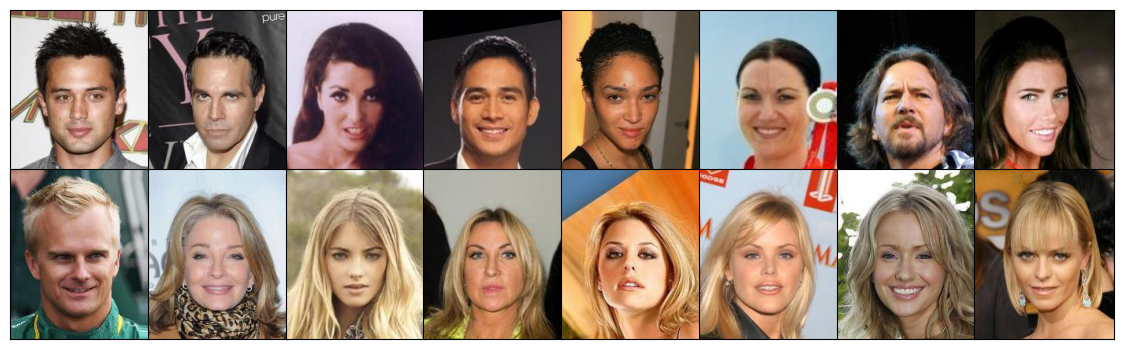

In [11]:
trainA=r"files/black/"
trainB=r"files/blond/"

import random
import matplotlib.pyplot as plt
from PIL import Image

imgs=os.listdir(trainA)
random.seed(42)
samples=random.sample(imgs,8)
imgs1=os.listdir(trainB)
random.seed(42)
samples1=random.sample(imgs1,8)
fs=[trainA,trainB]
ps=[imgs,imgs1]
fig=plt.figure(dpi=100, figsize=(1.78*8,2.18*2))
for i in range(16):
    ax = plt.subplot(2, 8, i + 1)
    folder=i//8
    p=i%8
    img=Image.open(fr"{fs[folder]}{ps[folder][p]}")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.01,hspace=-0.1)
plt.show() 

In [12]:
disc_A = Discriminator().to(device)
disc_B = Discriminator().to(device)
gen_A = Generator(img_channels=3, num_residuals=9).to(device)
gen_B = Generator(img_channels=3, num_residuals=9).to(device)
weights_init(gen_A)
weights_init(disc_A)
weights_init(gen_B)
weights_init(disc_B)
opt_disc = torch.optim.Adam(list(disc_A.parameters()) + 
  list(disc_B.parameters()),lr=lr,betas=(0.5, 0.999))
opt_gen = torch.optim.Adam(list(gen_A.parameters()) + 
  list(gen_B.parameters()),lr=lr,betas=(0.5, 0.999))

In [13]:
dataset = LoadData(root_A=["files/black/"],
    root_B=["files/blond/"],
    transform=transforms)
loader=DataLoader(dataset,batch_size=1,
    shuffle=True, pin_memory=True)
for epoch in range(1):
    train_epoch(disc_A, disc_B, gen_A, gen_B, loader, opt_disc,
    opt_gen, l1, mse, d_scaler, g_scaler, device)
torch.save(gen_A.state_dict(), "files/gen_black.pth")
torch.save(gen_B.state_dict(), "files/gen_blond.pth")

Download the pretrained model from my website https://gattonweb.uky.edu/faculty/lium/ml/hair.zip 

## 4.2. Test the Trained Generators
We'll use the trained model to first add eye glasses to all images without glasses and to remove glasses from images with glasses, as follows: 

In [14]:
gen_A.load_state_dict(torch.load("files/gen_black.pth"))
gen_B.load_state_dict(torch.load("files/gen_blond.pth"))
i=1
for black,blond in loader:
    fake_blond=gen_B(black.to(device))
    save_image(black*0.5+0.5,f"files/black{i}.png")
    save_image(fake_blond*0.5+0.5,f"files/fakeblond{i}.png")   
    fake2black=gen_A(fake_blond)
    save_image(fake2black*0.5+0.5,f"files/fake2black{i}.png")    
    fake_black=gen_A(blond.to(device))
    save_image(blond*0.5+0.5,f"files/blond{i}.png")
    save_image(fake_black*0.5+0.5,f"files/fakeblack{i}.png")
    fake2blond=gen_B(fake_black)
    save_image(fake2blond*0.5+0.5,f"files/fake2blond{i}.png")  
    i=i+1
    if i>10:
        break

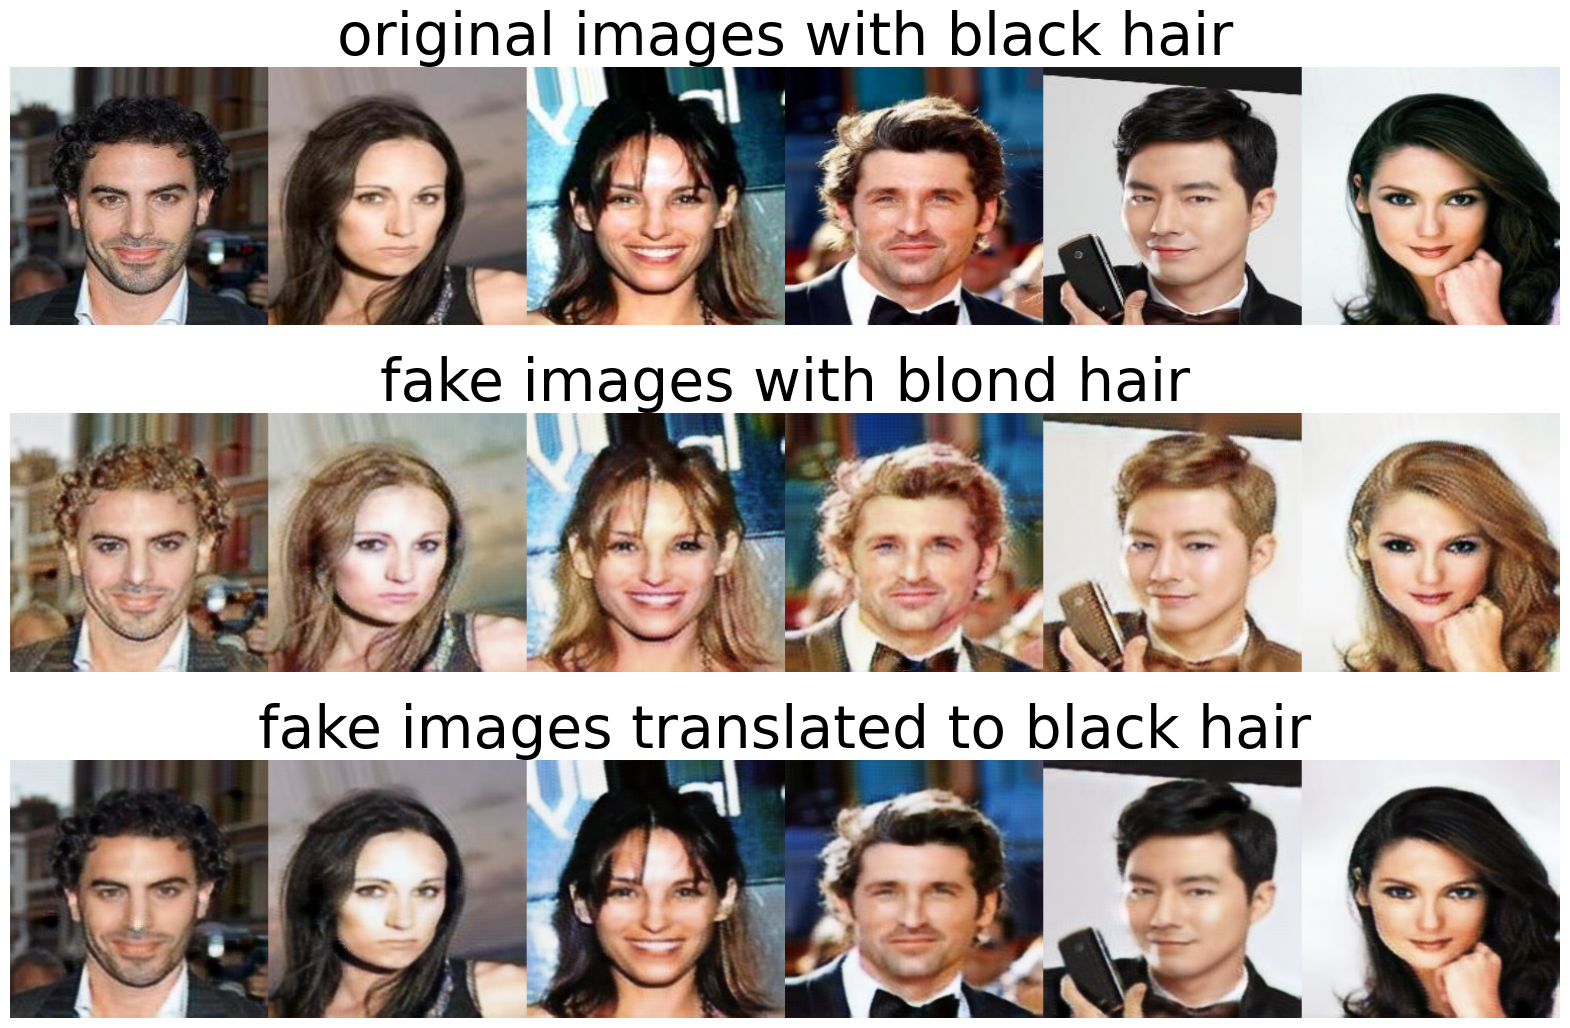




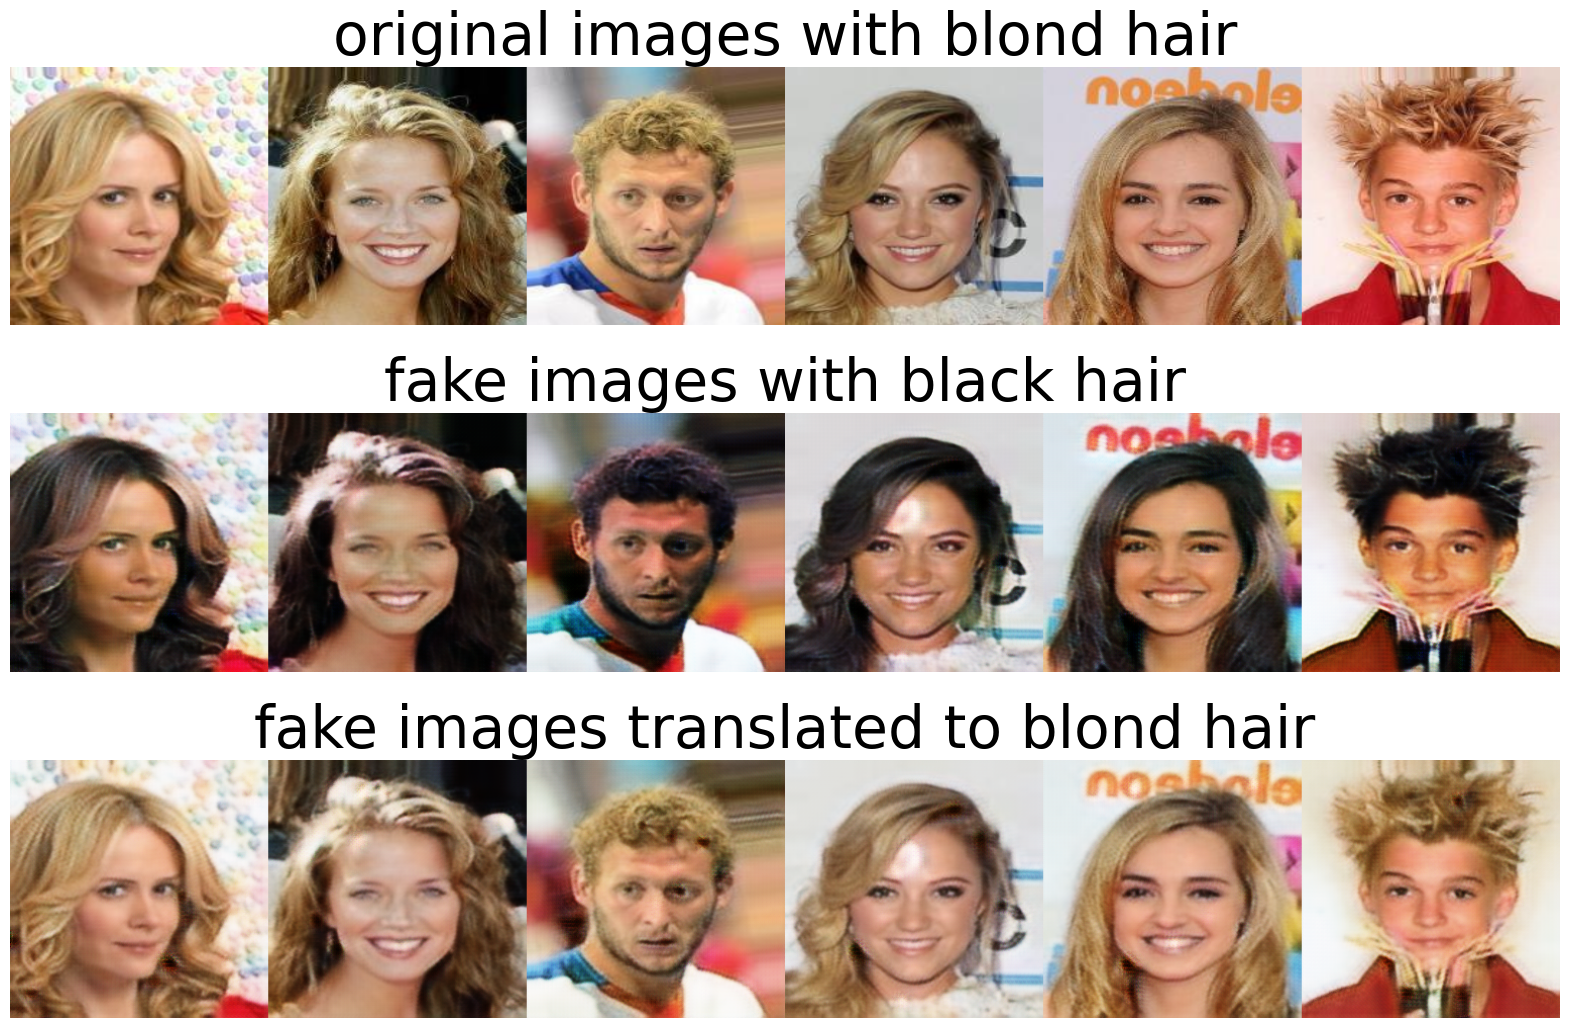

In [15]:
# solution to exercise 6.3

disc_A = Discriminator().to(device)
disc_B = Discriminator().to(device)
gen_A = Generator(img_channels=3, num_residuals=9).to(device)
gen_B = Generator(img_channels=3, num_residuals=9).to(device)
weights_init(gen_A)
weights_init(disc_A)
weights_init(gen_B)
weights_init(disc_B)
opt_disc = torch.optim.Adam(list(disc_A.parameters()) + 
  list(disc_B.parameters()),lr=lr,betas=(0.5, 0.999))
opt_gen = torch.optim.Adam(list(gen_A.parameters()) + 
  list(gen_B.parameters()),lr=lr,betas=(0.5, 0.999))

dataset = LoadData(root_A=['files/glasses/G/'],
    root_B=['files/glasses/NoG/'],
    transform=transforms)
loader=DataLoader(dataset,batch_size=1,
    shuffle=True, pin_memory=True)
for epoch in range(1):
    train_epoch(disc_A, disc_B, gen_A, gen_B, loader, opt_disc,
    opt_gen, l1, mse, d_scaler, g_scaler, device)
torch.save(gen_A.state_dict(), "files/add_glasses.pth")
torch.save(gen_B.state_dict(), "files/remove_glasses.pth")

<img src="https://gattonweb.uky.edu/faculty/lium/ml/removeglasses.jpg" />   

<img src="https://gattonweb.uky.edu/faculty/lium/ml/addglasses.jpg" />   